In [1]:
# first draw tokens distribution:

import os
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import pickle

def update_x(x):
    if x == ' ':
        return '\\s'
    elif x == '\n':
        return '\\n'
    return x


meta_path = 'nanoGPT/data/shakespeare_char/meta.pkl'
load_meta = os.path.exists(meta_path)
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)
    # TODO want to make this more general to arbitrary encoder/decoder schemes
stoi, itos = meta['stoi'], meta['itos']
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data_dir = 'nanoGPT/data/shakespeare_char'
data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')

counter = Counter(data)
counts = np.array(sorted(counter.values(), reverse=True))

decoded_tokens = list(counter.items())
decoded_tokens = sorted(decoded_tokens, key=lambda x: x[1], reverse=True)
decoded_tokens = [int(x[0]) for x in decoded_tokens]
decoded_tokens = list(decode(decoded_tokens))

decoded_tokens = [update_x(x) for x in decoded_tokens]

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

state_dict_paths = {
    'baseline': 'nanoGPT/out/baseline_logged/grad_logger_state_dict.pth',
    'margin_2': 'nanoGPT/out/proposed_margin_2.0_logged/grad_logger_state_dict.pth'
}
key_1 = 'grad_input'
key_2_1 = 'grad_output_positive'
key_2_2 = 'grad_output_negative'

state_dicts = {name: torch.load(path) for name, path in state_dict_paths.items()}
               
numpy_arrays_dict = {}
for name, state_dict in state_dicts.items():
    numpy_arrays_dict[name] = {k: v.detach().numpy() for k, v in state_dict.items()}

sorted_tokens = [token for token, _ in counter.most_common()]

colors = {
    'baseline': '#6C8EBF',
    'margin_2': '#B85450',
}

name2label = {
    'baseline': 'Baseline',
    'margin_2': 'Proposed (margin=2)',
}

/tmp/ipykernel_259/2925632983.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dicts = {name: torch.load(path) for name, path in state_dict_paths.items()}


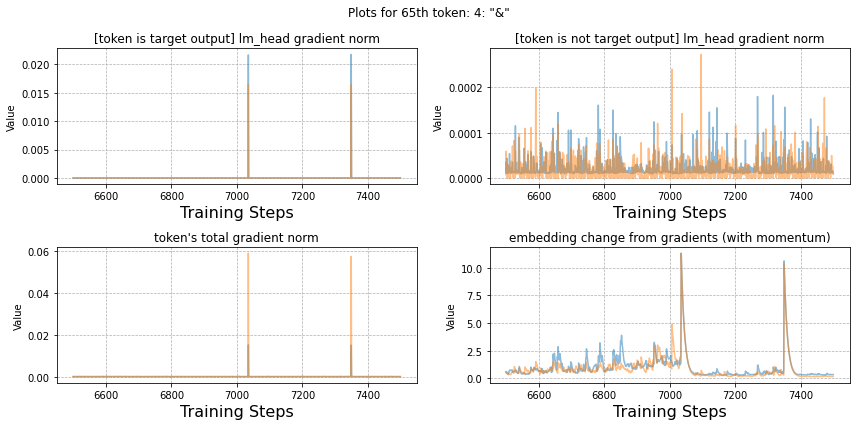

In [9]:
# Define the types of gradients
types = {
#     "grad_input": "wte gradient norm",
    "grad_output_positive": "[token is target output] lm_head gradient norm",
    "grad_output_negative": "[token is not target output] lm_head gradient norm",
    "grad_total": "token's total gradient norm",
    "grad_adam_moments": "embedding change from gradients (with momentum)",
}


# Iterate over the sorted tokens and create the required plots
token_index, token_id = 64, 4

numpy_arrays = numpy_arrays_dict['margin_2']

fig, axs = plt.subplots(2, 2, figsize=(12, 6))
fig.suptitle(f'Plots for {token_index+1}th token: {token_id}: "{decode([token_id])}"')

for i, (gradient_type, type_description) in enumerate(types.items()):
    ax = axs[i // 2, i % 2]
    for name, numpy_arrays in numpy_arrays_dict.items():
        x = np.arange(len(numpy_arrays[gradient_type][:, token_id]))
        y = numpy_arrays[gradient_type][:, token_id]
        ax.plot(x[6500:7500], y[6500:7500], alpha=0.5)
    ax.set_title(type_description)
    ax.set_xlabel('Training Steps', fontsize=16)
    ax.set_ylabel('Value')
#     if gradient_type == 'grad_output_negative':
#         ax.set_ylim(top=4e-5)
#     elif gradient_type == 'grad_adam_moments':
#         ax.set_ylim(top=1)
#     ax.set_xlim((0, 8000))
#     ax.set_yscale('log')
    ax.grid(True, which='major', linestyle='--', linewidth=0.7) # , axis='y')


plt.tight_layout()
plt.show()